In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(1, "../..")
from simulations import laub_loomis
from itertools import product
from prototype_nn import Splitting, predictions, tensor_flatten
import matplotlib.pyplot as plt
import prototype
import torch
%run ../utilities.ipynb

## Training : Simulations

In [48]:
training = pd.DataFrame(data = pd.read_csv("../../data/train/laub.csv"))
training.head()

,time,x,y,z,w,p,q,m,initial_x,initial_y,initial_z,initial_w,initial_p,initial_q,initial_m
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,1,1
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,1,1,1,1,1,1,1
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,1,1,1,1,1,1,1
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,1,1,1,1,1,1,1
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,1,1,1,1,1,1,1


In [3]:
len(training)

640000

In [4]:
kfold = Splitting([0,8,9,10,11,12,13,14], [1,2,3,4,5,6,7], num_epoches = 5, batch_size = 32, lr= 0.00005)

In [107]:
evaluate = kfold.cross_validation_evaluate(training, 5)

------------- Fold 0 -------------
TEST: 0 TRAIN: [1, 2, 3, 4]
Epoch: 0  Train Loss: 0.0005632030661217868 
Epoch: 1  Train Loss: 0.00016792445967439562 
Epoch: 2  Train Loss: 0.00020622866577468812 
Epoch: 3  Train Loss: 0.0005936590023338795 
Epoch: 4  Train Loss: 2.636654426169116e-05 
------------- Fold 1 -------------
TEST: 1 TRAIN: [0, 2, 3, 4]
Epoch: 0  Train Loss: 0.00010425614163978025 
Epoch: 1  Train Loss: 0.00026528368471190333 
Epoch: 2  Train Loss: 0.00023547207820229232 
Epoch: 3  Train Loss: 5.427421456261072e-06 
Epoch: 4  Train Loss: 0.00032659564749337733 
------------- Fold 2 -------------
TEST: 2 TRAIN: [0, 1, 3, 4]
Epoch: 0  Train Loss: 3.843784725177102e-05 
Epoch: 1  Train Loss: 0.0005244789062999189 
Epoch: 2  Train Loss: 0.0006629665731452405 
Epoch: 3  Train Loss: 1.2621449059224688e-05 
Epoch: 4  Train Loss: 4.9928024964174256e-05 
------------- Fold 3 -------------
TEST: 3 TRAIN: [0, 1, 2, 4]
Epoch: 0  Train Loss: 0.0009734859922900796 
Epoch: 1  Train Loss

In [108]:
evaluate

[tensor(0.0001, grad_fn=<MseLossBackward>),
 tensor(0.0003, grad_fn=<MseLossBackward>),
 tensor(9.0856e-05, grad_fn=<MseLossBackward>),
 tensor(0.0001, grad_fn=<MseLossBackward>),
 tensor(0.0001, grad_fn=<MseLossBackward>)]

In [109]:
average_loss = 0
for x in evaluate:
    average_loss += x.item()
average_loss/len(evaluate)

0.0001710399446892552

In [5]:
training['initial_parameters'] = list(zip(training.initial_x, 
                                          training.initial_y,
                                          training.initial_z,
                                          training.initial_w,
                                          training.initial_p,
                                          training.initial_q,
                                          training.initial_m,))
training = training.drop(columns = ["initial_x","initial_y","initial_z","initial_w","initial_p","initial_q","initial_m"])
training.head()

,time,x,y,z,w,p,q,m,initial_parameters
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"(1, 1, 1, 1, 1, 1, 1)"
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,"(1, 1, 1, 1, 1, 1, 1)"
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,"(1, 1, 1, 1, 1, 1, 1)"
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,"(1, 1, 1, 1, 1, 1, 1)"
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,"(1, 1, 1, 1, 1, 1, 1)"


In [6]:
initial = training[training["initial_parameters"] == (1, 1, 1, 1, 1, 1, 1)]

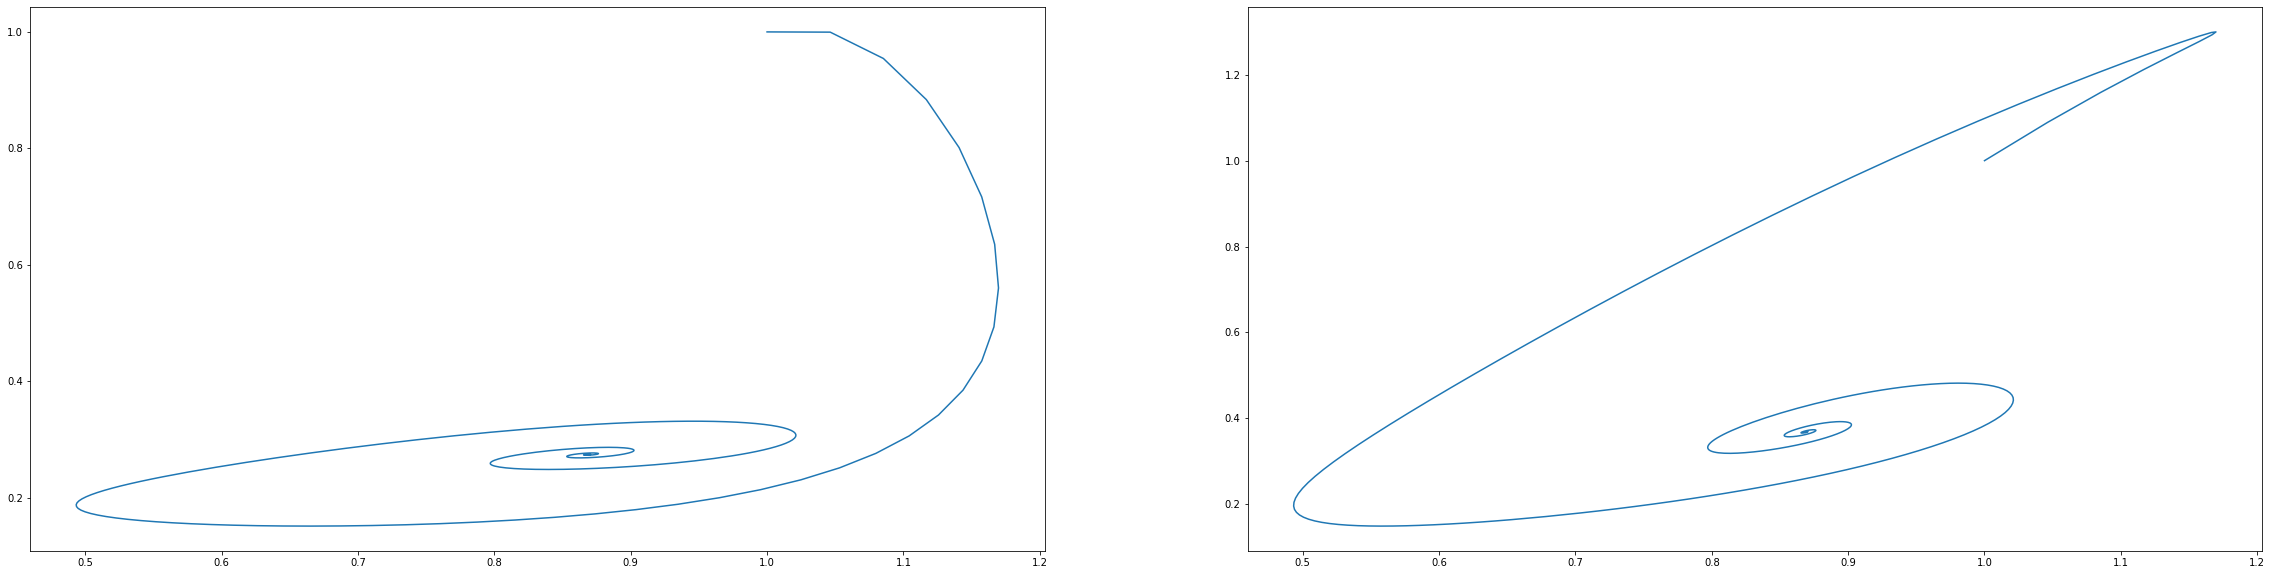

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(40,10))
ax[0].plot(initial[["x"]], initial[["m"]])
ax[1].plot(initial[["x"]], initial[["y"]])

## Training : Predictions

In [8]:
training_predictions = pd.DataFrame(data=pd.read_csv("../../data/train/laub.csv"))
training_predictions.head()

,time,x,y,z,w,p,q,m,initial_x,initial_y,initial_z,initial_w,initial_p,initial_q,initial_m
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,1,1
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,1,1,1,1,1,1,1
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,1,1,1,1,1,1,1
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,1,1,1,1,1,1,1
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,1,1,1,1,1,1,1


In [9]:
training_predictions['initial_parameters'] = list(zip(training_predictions.initial_x, 
                                          training_predictions.initial_y,
                                          training_predictions.initial_z,
                                          training_predictions.initial_w,
                                          training_predictions.initial_p,
                                          training_predictions.initial_q,
                                          training_predictions.initial_m,))
training_predictions = training_predictions.drop(columns = ["initial_x","initial_y","initial_z","initial_w","initial_p","initial_q","initial_m"])
training_predictions = training_predictions.rename(columns = {"x" : "x_preds", 
                                           "y" : "y_preds",
                                           "z" : "z_preds",
                                           "w" : "w_preds",
                                           "p" : "p_preds",
                                           "q" : "q_preds",
                                           "m" : "m_preds"})
training_predictions.head()

,time,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds,initial_parameters
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"(1, 1, 1, 1, 1, 1, 1)"
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,"(1, 1, 1, 1, 1, 1, 1)"
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,"(1, 1, 1, 1, 1, 1, 1)"
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,"(1, 1, 1, 1, 1, 1, 1)"
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,"(1, 1, 1, 1, 1, 1, 1)"


In [10]:
training_and_predictions = pd.merge(training, training_predictions, right_on = ["time", "initial_parameters"],
                                    left_on = ["time", "initial_parameters"])

In [11]:
training_and_predictions.head()

,time,x,y,z,w,p,q,m,initial_parameters,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"(1, 1, 1, 1, 1, 1, 1)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,"(1, 1, 1, 1, 1, 1, 1)",1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,"(1, 1, 1, 1, 1, 1, 1)",1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,"(1, 1, 1, 1, 1, 1, 1)",1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,"(1, 1, 1, 1, 1, 1, 1)",1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426


In [12]:
initial = training_and_predictions[training_and_predictions["initial_parameters"] == (1, 1, 1, 1, 1, 1, 1)]

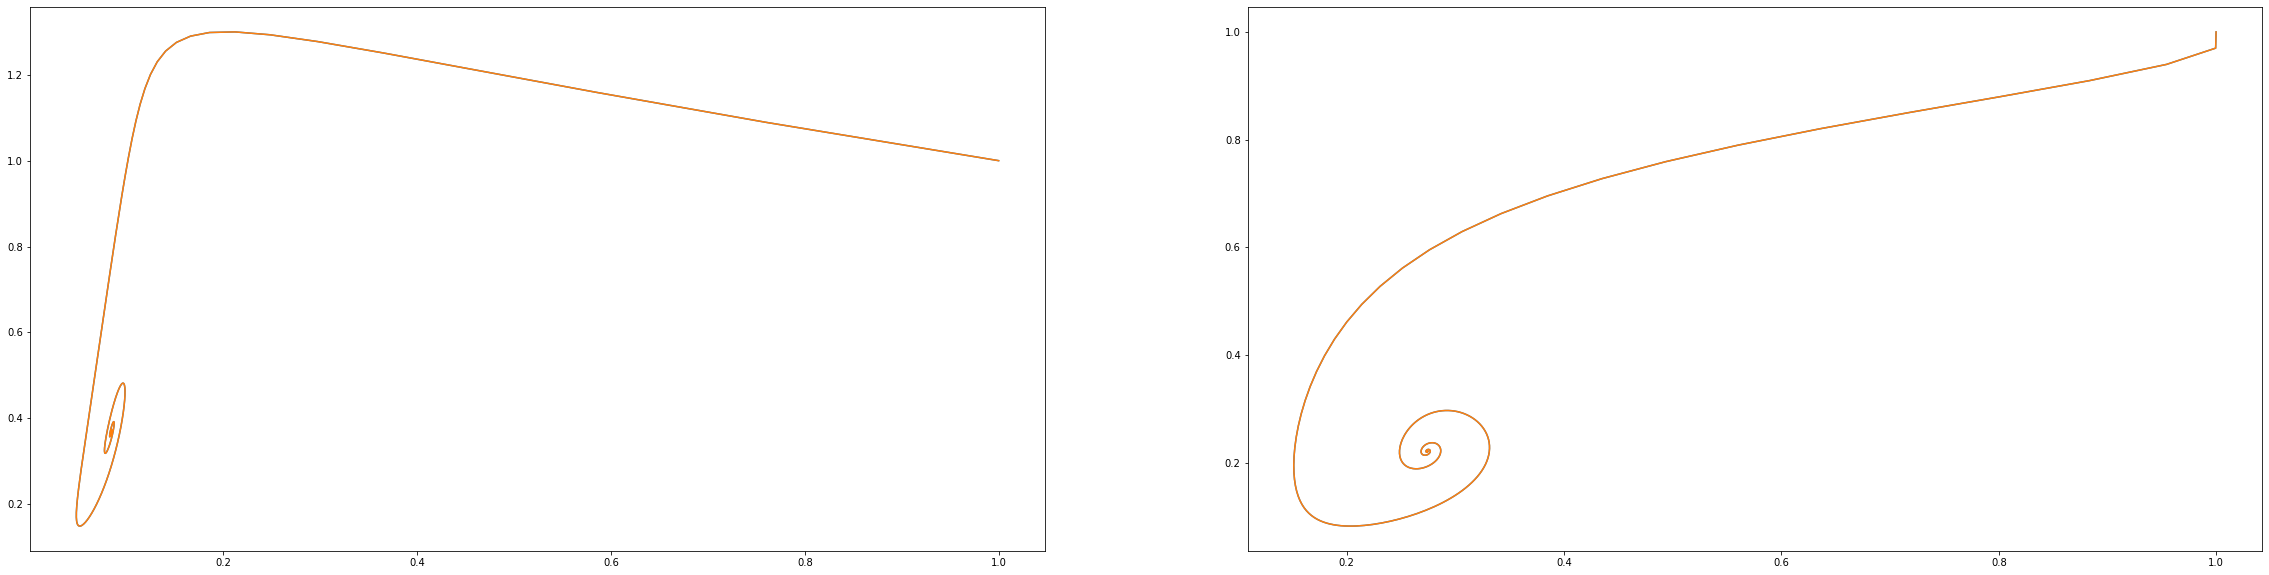

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(40,10))
ax[0].plot(initial[["q"]], initial[["y"]])
ax[0].plot(initial[["q_preds"]], initial[["y_preds"]])

ax[1].plot(initial[["m"]], initial[["p"]])
ax[1].plot(initial[["m_preds"]], initial[["p_preds"]])

## Testing : Simulations

In [14]:
testing = laub_loomis(delta = 0.1, simulations = 500, save = False, initial_paras = np.round(np.random.uniform(0, 4, 2), 2))
testing.head()

,time,x,y,z,w,p,q,m,initial_x,initial_y,initial_z,initial_w,initial_p,initial_q,initial_m
0,0.0,2.300000,2.300000,2.300000,2.300000,2.300000,2.300000,2.300000,2.3,2.3,2.3,2.3,2.3,2.3,2.3
1,0.1,2.390475,2.476805,2.013142,1.912659,2.015034,1.747588,1.906156,2.3,2.3,2.3,2.3,2.3,2.3,2.3
2,0.2,2.435274,2.577355,1.736768,1.677268,1.840911,1.344126,1.531572,2.3,2.3,2.3,2.3,2.3,2.3,2.3
3,0.3,2.440690,2.631268,1.483455,1.541870,1.726340,1.048815,1.211381,2.3,2.3,2.3,2.3,2.3,2.3,2.3
4,0.4,2.413621,2.655231,1.258497,1.474241,1.643341,0.831904,0.952419,2.3,2.3,2.3,2.3,2.3,2.3,2.3


In [15]:
len(testing)

640000

In [16]:
testing['initial_parameters'] = list(zip(testing.initial_x, 
                                          testing.initial_y,
                                          testing.initial_z,
                                          testing.initial_w,
                                          testing.initial_p,
                                          testing.initial_q,
                                          testing.initial_m,))

In [18]:
testing.head()

,time,x,y,z,w,p,q,m,initial_x,initial_y,initial_z,initial_w,initial_p,initial_q,initial_m,initial_parameters
0,0.0,2.300000,2.300000,2.300000,2.300000,2.300000,2.300000,2.300000,2.3,2.3,2.3,2.3,2.3,2.3,2.3,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
1,0.1,2.390475,2.476805,2.013142,1.912659,2.015034,1.747588,1.906156,2.3,2.3,2.3,2.3,2.3,2.3,2.3,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
2,0.2,2.435274,2.577355,1.736768,1.677268,1.840911,1.344126,1.531572,2.3,2.3,2.3,2.3,2.3,2.3,2.3,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
3,0.3,2.440690,2.631268,1.483455,1.541870,1.726340,1.048815,1.211381,2.3,2.3,2.3,2.3,2.3,2.3,2.3,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
4,0.4,2.413621,2.655231,1.258497,1.474241,1.643341,0.831904,0.952419,2.3,2.3,2.3,2.3,2.3,2.3,2.3,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"


In [19]:
def testing_preds(test_df):
    inputs = torch.tensor(test_df.iloc[ :, [0,8,9,10,11,12,13,14]].values)
    targets = torch.tensor(test_df.iloc[:, [1,2,3,4,5,6,7]].values)
    preds, _ = predictions(num_inputs=8, num_classes=7, learning_rate=0.0005, batch_size=1, num_epochs=1, inputs=inputs.float(), targets=targets.float(), train=False, path= "../../data/state/loomis.pth")
    data = {'time' : test_df.time.values,
            'initial_parameters' : test_df.initial_parameters.values,
            'x' : tensor_flatten(preds[:,0]), 'y' : tensor_flatten(preds[:, 1]), 
            'z' : tensor_flatten(preds[:, 2]), 'w' : tensor_flatten(preds[:, 3]),
            'p' : tensor_flatten(preds[:, 4]), 'q' : tensor_flatten(preds[:, 5]), 
            'm' : tensor_flatten(preds[:, 6])}
    return pd.DataFrame(data = data, columns = ["time", "x", "y", "z", "w", "p", "q", "m", "initial_parameters"]);

In [20]:
testing_predictions = testing_preds(testing)
testing_predictions.head()

,time,x,y,z,w,p,q,m,initial_parameters
0,0.0,2.106529,2.074410,1.892468,1.796876,2.111202,1.994600,2.217647,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
1,0.1,2.157917,2.169866,1.756134,1.745835,2.039726,1.784348,2.002864,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
2,0.2,2.206223,2.264864,1.616271,1.696587,1.964335,1.570204,1.784439,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
3,0.3,2.251359,2.362035,1.472112,1.647114,1.887219,1.351035,1.560532,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
4,0.4,2.294314,2.457323,1.325914,1.601619,1.805319,1.127157,1.331245,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"


In [21]:
testing = testing.drop(columns = ["initial_x","initial_y","initial_z","initial_w","initial_p","initial_q","initial_m"])
testing.head()

,time,x,y,z,w,p,q,m,initial_parameters
0,0.0,2.300000,2.300000,2.300000,2.300000,2.300000,2.300000,2.300000,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
1,0.1,2.390475,2.476805,2.013142,1.912659,2.015034,1.747588,1.906156,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
2,0.2,2.435274,2.577355,1.736768,1.677268,1.840911,1.344126,1.531572,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
3,0.3,2.440690,2.631268,1.483455,1.541870,1.726340,1.048815,1.211381,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
4,0.4,2.413621,2.655231,1.258497,1.474241,1.643341,0.831904,0.952419,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"


In [22]:
testing_predictions = testing_predictions.rename(columns = {"x" : "x_preds", 
                                           "y" : "y_preds",
                                           "z" : "z_preds",
                                           "w" : "w_preds",
                                           "p" : "p_preds",
                                           "q" : "q_preds",
                                           "m" : "m_preds"})
testing_predictions.head()

,time,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds,initial_parameters
0,0.0,2.106529,2.074410,1.892468,1.796876,2.111202,1.994600,2.217647,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
1,0.1,2.157917,2.169866,1.756134,1.745835,2.039726,1.784348,2.002864,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
2,0.2,2.206223,2.264864,1.616271,1.696587,1.964335,1.570204,1.784439,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
3,0.3,2.251359,2.362035,1.472112,1.647114,1.887219,1.351035,1.560532,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
4,0.4,2.294314,2.457323,1.325914,1.601619,1.805319,1.127157,1.331245,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"


In [23]:
testing_and_predictions = pd.merge(testing, testing_predictions, right_on = ["time", "initial_parameters"],
                                    left_on = ["time", "initial_parameters"])

In [24]:
testing_and_predictions.head()

,time,x,y,z,w,p,q,m,initial_parameters,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds
0,0.0,2.300000,2.300000,2.300000,2.300000,2.300000,2.300000,2.300000,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)",2.106529,2.074410,1.892468,1.796876,2.111202,1.994600,2.217647
1,0.1,2.390475,2.476805,2.013142,1.912659,2.015034,1.747588,1.906156,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)",2.157917,2.169866,1.756134,1.745835,2.039726,1.784348,2.002864
2,0.2,2.435274,2.577355,1.736768,1.677268,1.840911,1.344126,1.531572,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)",2.206223,2.264864,1.616271,1.696587,1.964335,1.570204,1.784439
3,0.3,2.440690,2.631268,1.483455,1.541870,1.726340,1.048815,1.211381,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)",2.251359,2.362035,1.472112,1.647114,1.887219,1.351035,1.560532
4,0.4,2.413621,2.655231,1.258497,1.474241,1.643341,0.831904,0.952419,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)",2.294314,2.457323,1.325914,1.601619,1.805319,1.127157,1.331245


In [25]:
initial = testing_and_predictions[testing_and_predictions["initial_parameters"] == (2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)]

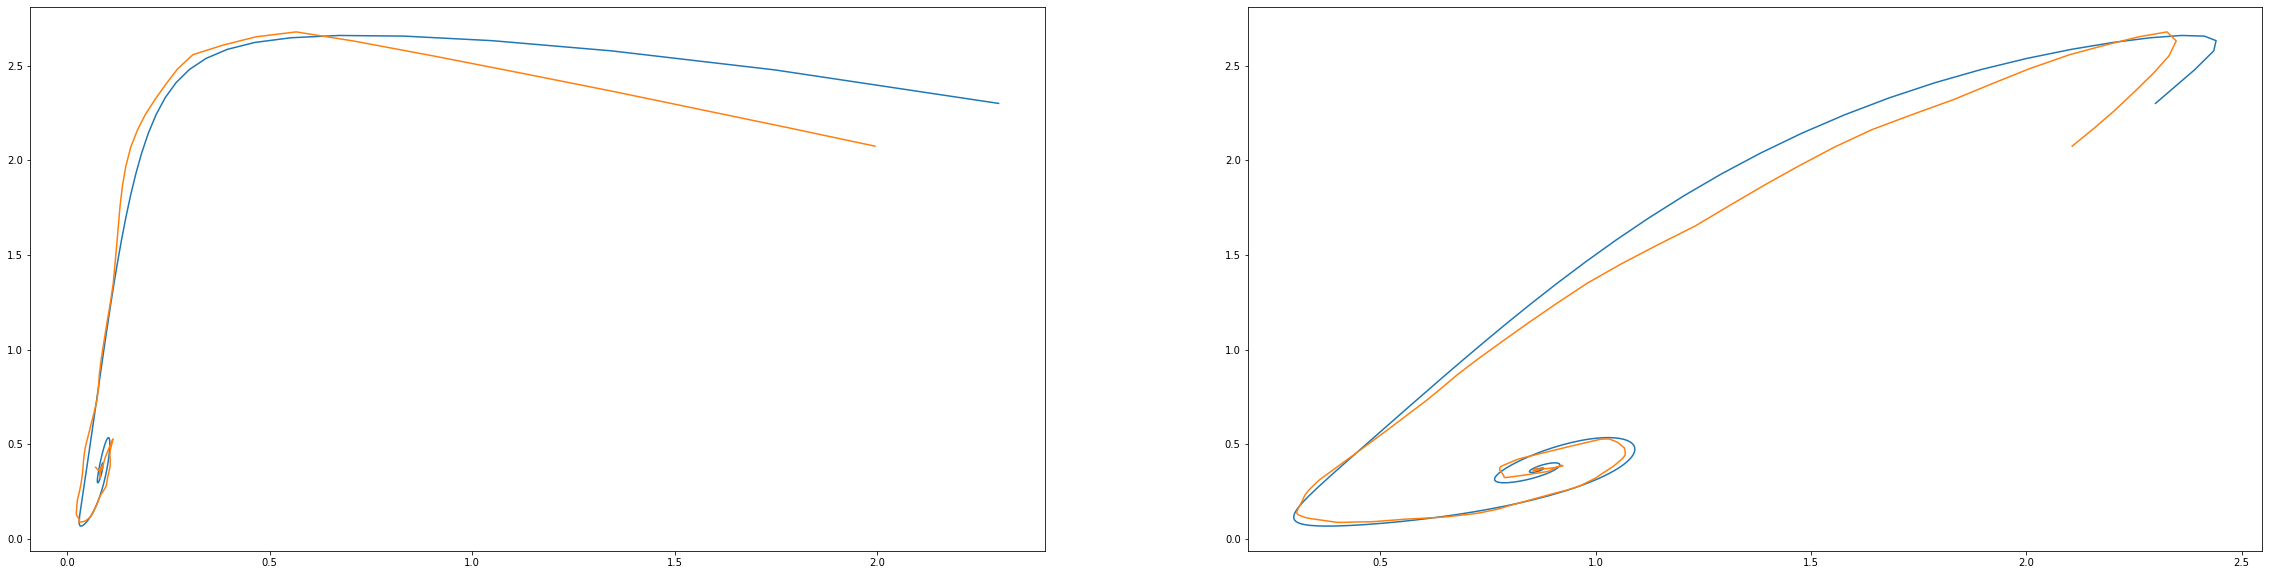

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(40,10))
ax[0].plot(initial[["q"]], initial[["y"]])
ax[0].plot(initial[["q_preds"]], initial[["y_preds"]])

ax[1].plot(initial[["x"]], initial[["y"]])
ax[1].plot(initial[["x_preds"]], initial[["y_preds"]])

### Loss by simulation

This is caculating the loss by testing simulation. This goes through every simulation within the testing data and caculates the loss.

Below are the dataframes where using: 
<ol>
    <li>testing - holds the testing simulations</li>
    <li> testing_predictions - holds the predictions of the testing simulation </li>
</ol>

In [27]:
testing.head()

,time,x,y,z,w,p,q,m,initial_parameters
0,0.0,2.300000,2.300000,2.300000,2.300000,2.300000,2.300000,2.300000,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
1,0.1,2.390475,2.476805,2.013142,1.912659,2.015034,1.747588,1.906156,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
2,0.2,2.435274,2.577355,1.736768,1.677268,1.840911,1.344126,1.531572,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
3,0.3,2.440690,2.631268,1.483455,1.541870,1.726340,1.048815,1.211381,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
4,0.4,2.413621,2.655231,1.258497,1.474241,1.643341,0.831904,0.952419,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"


In [28]:
testing_predictions.head()

,time,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds,initial_parameters
0,0.0,2.106529,2.074410,1.892468,1.796876,2.111202,1.994600,2.217647,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
1,0.1,2.157917,2.169866,1.756134,1.745835,2.039726,1.784348,2.002864,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
2,0.2,2.206223,2.264864,1.616271,1.696587,1.964335,1.570204,1.784439,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
3,0.3,2.251359,2.362035,1.472112,1.647114,1.887219,1.351035,1.560532,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"
4,0.4,2.294314,2.457323,1.325914,1.601619,1.805319,1.127157,1.331245,"(2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3)"


This is going through a function which caculates the loss for each simulation

In [29]:
simulationLoss, _ = lossBySimulations(testing, testing_predictions, [1,2,3,4,5,6,7])

The dataframe it provides, we see each simulation (initial_parameters) corresponds to a loss

In [30]:
simulationLoss

,initial_parameters,Loss
0,0.76 0.76 0.76 0.76 0.76 0.76 0.76,0.000685
1,0.76 0.76 0.76 0.76 0.76 0.76 2.3,0.000665
2,0.76 0.76 0.76 0.76 0.76 2.3 0.76,0.000926
3,0.76 0.76 0.76 0.76 0.76 2.3 2.3,0.000645
4,0.76 0.76 0.76 0.76 2.3 0.76 0.76,0.000608
...,...,...
123,2.3 2.3 2.3 2.3 0.76 2.3 2.3,0.000747
124,2.3 2.3 2.3 2.3 2.3 0.76 0.76,0.000550
125,2.3 2.3 2.3 2.3 2.3 0.76 2.3,0.000661
126,2.3 2.3 2.3 2.3 2.3 2.3 0.76,0.000487


This function shows the plotted dataframe on the bar graph

In [31]:
initial_values = [np.arange(1,3,1),np.arange(1,3,1),np.arange(1,3,1),np.arange(1,3,1),np.arange(1,3,1),np.arange(1,3,1),np.arange(1,3,1)]

In [44]:
simulationLossDistance = lossBySimulationsDistance(simulationLoss, initial_values)

In [45]:
simulationLossDistance.head()

,initial_parameters,Loss,Distance
0,0.76 0.76 0.76 0.76 0.76 0.76 0.76,0.000685,3.900386
16,0.76 0.76 2.3 0.76 0.76 0.76 0.76,0.000749,3.947116
64,2.3 0.76 0.76 0.76 0.76 0.76 0.76,0.000726,3.947116
8,0.76 0.76 0.76 2.3 0.76 0.76 0.76,0.000635,3.947116
32,0.76 2.3 0.76 0.76 0.76 0.76 0.76,0.000578,3.947116


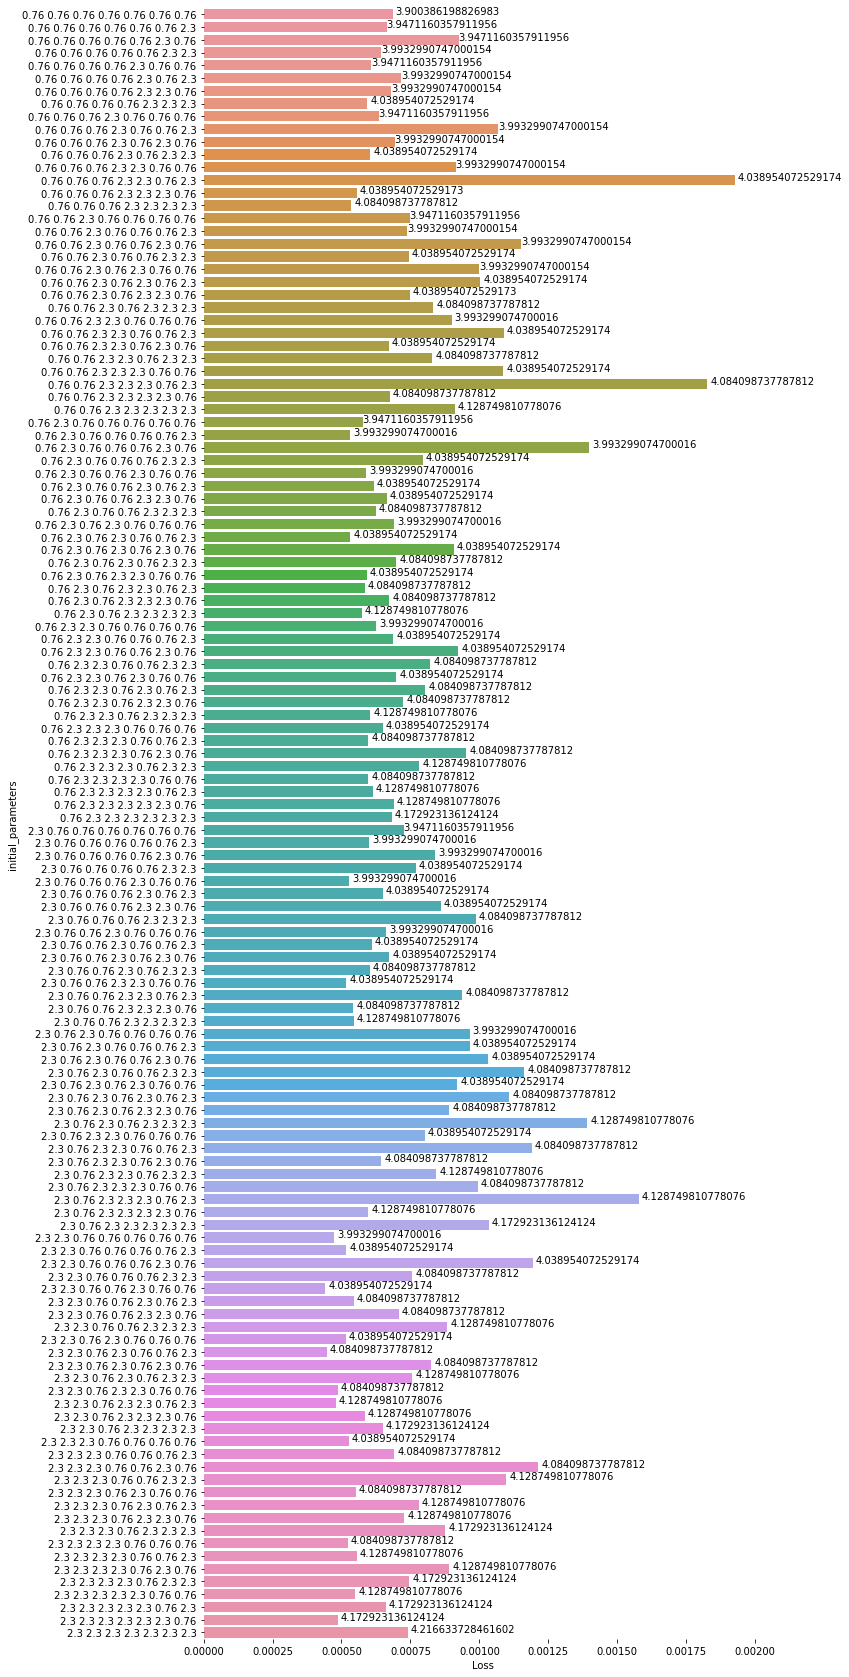

In [99]:
simulaPlots("Loss", "initial_parameters", simulationLoss, figsize = (10,30), pos = 0.0002)

This is going through a function which allows us to see the loss for each individual time within the dataframe

In [101]:
timeLoss, _ = lossByTime(testing, testing_predictions, [1,2,3,4,5,6,7])

This returns a dataframe shown below

In [102]:
timeLoss.head()

,Time,initial_parameters,Loss
0,0.0,"(0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76)",0.154433
1,0.1,"(0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76)",0.096370
2,0.2,"(0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76)",0.062209
3,0.3,"(0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76)",0.046158
4,0.4,"(0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76)",0.038026


In [103]:
individualTimeLoss = timeLoss.groupby("Time").sum("Loss").reset_index()

In [104]:
individualTimeLoss.head()

,Time,Loss
0,0.0,31.122456
1,0.1,15.239170
2,0.2,8.966240
3,0.3,6.404990
4,0.4,5.245202


This is the graph of the simulation

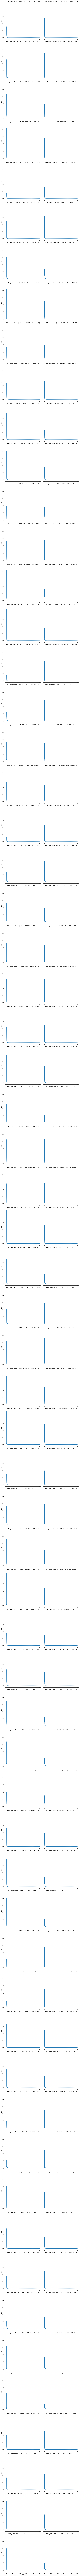

In [105]:
g = sns.FacetGrid(data = timeLoss, col = "initial_parameters", height = 5, col_wrap=2)
g.map(sns.lineplot, "Time", "Loss", ci=None)
g.add_legend()

<AxesSubplot:xlabel='Time', ylabel='Loss'>

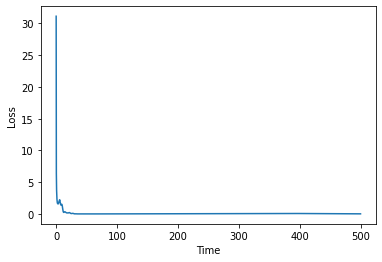

In [106]:
sns.lineplot(data = individualTimeLoss, x = "Time", y = "Loss")